<a href="https://colab.research.google.com/github/hindia-vic/potato_disease_classification/blob/main/potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faysalmiah1721758/potato-dataset")

print("Path to dataset files:", path)

100%|██████████| 37.8M/37.8M [00:01<00:00, 31.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faysalmiah1721758/potato-dataset/versions/1


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
#list files in potato-dataset
import os
os.listdir(path)


['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(path,batch_size=32,image_size=(256,256),shuffle=True)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 2 0 0 0 0 0 1 1 0 1 0]


Label: Potato___healthy


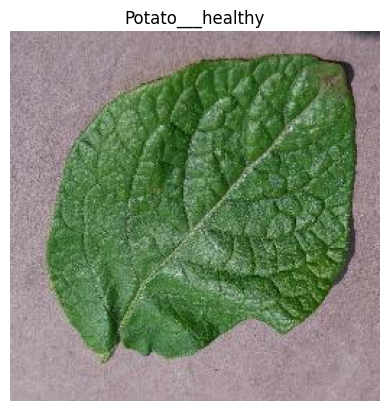

In [ ]:
for image_batch,labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    print("Label:",class_names[labels_batch[0]])
    plt.axis("off")

In [ ]:
#splittig data to train,test and validation
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
test=dataset.skip(54)
len(test)

14

In [ ]:
val_ds=test.take(6)
len(val_ds)

6

In [ ]:
test_ds=test.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)

])

In [ ]:
#applying data augmentation
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
model=models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax"),
])
model.build()


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history=model.fit(train_ds,batch_size=32,validation_data=val_ds,epochs=10)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.5207 - loss: 0.9191 - val_accuracy: 0.7604 - val_loss: 0.6209
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.8308 - loss: 0.4702 - val_accuracy: 0.7656 - val_loss: 0.5923
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.8721 - loss: 0.3520 - val_accuracy: 0.8958 - val_loss: 0.3439
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.8950 - loss: 0.2837 - val_accuracy: 0.8958 - val_loss: 0.3138
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.9280 - loss: 0.2069 - val_accuracy: 0.9115 - val_loss: 0.3203
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.9412 - loss: 0.1633 - val_accuracy: 0.9219 - val_loss: 0.1876
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.9375 - loss: 0.1558 - val_accuracy: 0.9375 - val_loss: 0.1490
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.9536 - loss: 0.1293 - val_accuracy: 0.9167 - v

In [ ]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9277 - loss: 0.1774


[0.217174232006073, 0.921875]

In [ ]:
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 54}

Text(0.5, 1.0, 'Accuracy')

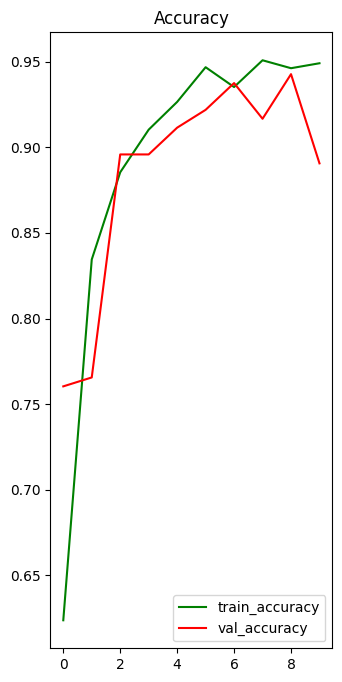

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],color="green",label="train_accuracy")
plt.plot(history.history["val_accuracy"],color="red",label="val_accuracy")
plt.legend()
plt.title("Accuracy")


Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: Potato___Late_blight


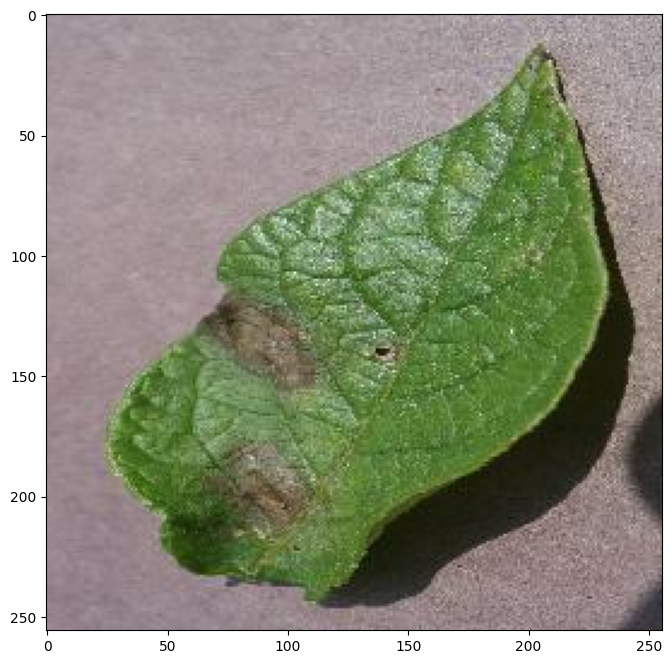

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  plt.figure(figsize=(8,8))
  first_image=images_batch[0].numpy().astype("uint8")
  plt.imshow(first_image)
  print("Actual label:",class_names[labels_batch[0]])
  batch_prediction=model.predict(images_batch)
  print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)

  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


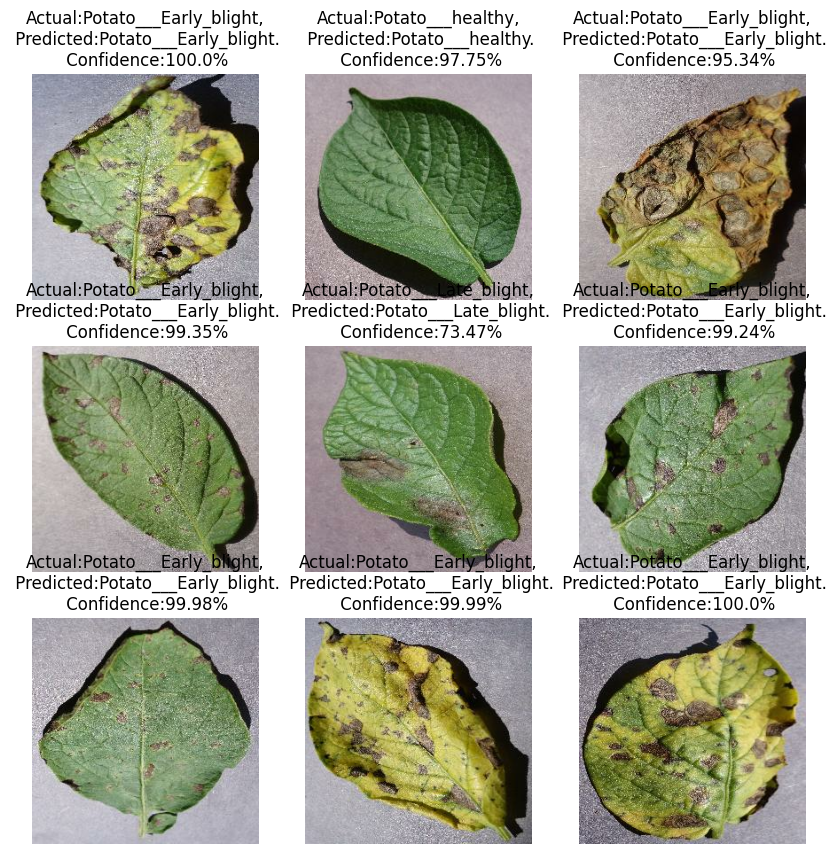

In [ ]:
for images,labels in test_ds.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax=plt.subplot(3,3,i+1)

    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())
    plt.title(f"Actual:{class_names[labels[i]]},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off")

In [ ]:
model.save("potato_disease.h5")

TypeError: cannot pickle 'module' object